# Self-Hosting Embedding Model on SageMaker

Hugging Face Embedding Leaderboard: https://huggingface.co/spaces/mteb/leaderboard

In [17]:
print("Input Hugging Face Model ID")
print("---------------------------")
print("Example: sentence-transformers/all-MiniLM-L6-v2")
print("https://huggingface.co/models?library=sentence-transformers")
print("")
HF_MODEL_ID = input()
print("")
print(f"HF_MODEL_ID = {HF_MODEL_ID}")

Input Hugging Face Model ID
---------------------------
Example: sentence-transformers/all-MiniLM-L6-v2
https://huggingface.co/models?library=sentence-transformers



 sentence-transformers/all-MiniLM-L6-v2



HF_MODEL_ID = sentence-transformers/all-MiniLM-L6-v2


## Prerequisites

### Set up

---
We begin by installing and upgrading necessary packages. Restart the kernel after executing the cell below for the first time.

---

In [3]:
!pip install -Uq sagemaker transformers langchain


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
### restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [6]:
import boto3
import sagemaker

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()  # account_id of the current SageMaker Studio environment
bucket = sess.default_bucket()  # bucket to house artifacts

sm_client = boto3.client("sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Download Embedding Model from Hugging Face

In [6]:
from pathlib import Path

model_path = f"{HF_MODEL_ID.replace('/', '_')}"
Path(model_path).mkdir(parents=True, exist_ok=True)

In [7]:
from huggingface_hub import snapshot_download

#HF_MODEL_ID="sentence-transformers/all-MiniLM-L6-v2"
#HF_TOKEN=<Your HF Token>

model_path = snapshot_download(repo_id=HF_MODEL_ID, 
                               #token=HF_TOKEN,
                               ignore_patterns=["*.ot", "*.h5"], 
                               cache_dir=model_path,
                               local_dir=model_path, 
                               local_dir_use_symlinks=False)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

## Deploy Model

Before deploying your model on SageMaker, you must package your model artifacts in a .tar.gz file. 

The following is an example of a `model.tar.gz` structure:

```bash
model.tar.gz/
|- pytorch_model.bin
|- ....
|- code/
  |- inference.py
  |- requirements.txt 
```

The `inference.py` file contains your custom inference module, and the `requirements.txt` file contains additional dependencies that should be added. The custom module can override the following methods:
- `model_fn(model_dir)` overrides the default method for loading a model. 
- `input_fn(input_data, content_type)` overrides the default method for preprocessing.
    - input_data is the raw body of your request.
    - content_type is the content type from the request header.
- `predict_fn(processed_data, model)` overrides the default method for predictions.
- `output_fn(prediction, accept)` overrides the default method for postprocessing. The inputs are:
    - predictions is the result from predict.
    - accept is the return accept type from the HTTP Request, e.g. application/json.

Here is an example of a custom inference module with `model_fn`, `input_fn`, `predict_fn`, and `output_fn`:

```python
def model_fn(model_dir):
    return "model"

def input_fn(data, content_type):
    return "data"

def predict_fn(data, model):
    return "output"

def output_fn(prediction, accept):
    return prediction
```

https://huggingface.co/docs/sagemaker/inference#user-defined-code-and-modules

In [41]:
%%writefile inference.py
from sentence_transformers import SentenceTransformer

def model_fn(model_dir):
    model = SentenceTransformer(model_dir)
    return model

def predict_fn(data, model):
    sentences = data["inputs"]
    embeddings = model.encode(sentences)
    print(embeddings)
    
    # return dictonary, which will be json serializable
    return {"vectors": embeddings.tolist()}

Writing inference.py


In [42]:
%%writefile requirements.txt
sentence_transformers

Writing requirements.txt


In [43]:
from pathlib import Path
import shutil

code_path = f"{HF_MODEL_ID.replace('/', '_')}/code"
Path(code_path).mkdir(parents=True, exist_ok=True)

shutil.move("inference.py", f"{HF_MODEL_ID.replace('/', '_')}/code/inference.py")
shutil.move("requirements.txt", f"{HF_MODEL_ID.replace('/', '_')}/code/requirements.txt")

'sentence-transformers_all-MiniLM-L6-v2/code/requirements.txt'

In [61]:
import tarfile
import os

# helper to create the model.tar.gz
def compress(tar_dir=None, ignore_extensions=[], output_file="model.tar.gz"):
    parent_dir=os.getcwd()
    os.chdir(tar_dir)
    with tarfile.open(os.path.join(parent_dir, output_file), "w:gz") as tar:
        for item in os.listdir('.'):
            if any(ext in item for ext in ignore_extensions):
                print(f"Ignore {item}")
                continue
            print(f"Add {item}")
            tar.add(item, arcname=item)     
    os.chdir(parent_dir)

compress(model_path, ignore_extensions=[]) #Eg. ignore_extensions=['.bin']

Add models--sentence-transformers--all-MiniLM-L6-v2
Add pytorch_model.bin
Add 1_Pooling
Add tokenizer_config.json
Add .ipynb_checkpoints
Add config.json
Add sentence_bert_config.json
Add modules.json
Add train_script.py
Add .gitattributes
Add special_tokens_map.json
Add vocab.txt
Add README.md
Add tokenizer.json
Add code
Add config_sentence_transformers.json
Add data_config.json


In [62]:
# upload files from local to S3 location
s3_embed_prefix = f"huggingface-hub/{HF_MODEL_ID}"

s3_embed_artifact = sess.upload_data("model.tar.gz", bucket, key_prefix=s3_embed_prefix)
print(f"Model artifact uploaded to --- > {s3_embed_artifact}")

Model artifact uploaded to --- > s3://sagemaker-us-east-1-468208999430/huggingface-hub/sentence-transformers/all-MiniLM-L6-v2/model.tar.gz


In [74]:
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig

name = sagemaker.utils.name_from_base(HF_MODEL_ID.split('/')[-1])

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(name=name,
                                     model_data=s3_embed_artifact,
                                     transformers_version='4.26.0',
                                     pytorch_version='1.13.1',
                                     py_version='py39',
                                     role=role 
                                    )

serverless_predictor = huggingface_model.deploy(endpoint_name=name, 
                                                serverless_inference_config=ServerlessInferenceConfig(
                                                    memory_size_in_mb=4096, 
                                                    max_concurrency=10
                                                ),
                                                wait=False
                                               ) 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
----!

In [ ]:
import time

while True:
    resp = sm_client.describe_endpoint(EndpointName=name)
    status = resp["EndpointStatus"]
    print("Status: " + status)
    if status != "Creating":
        break
    time.sleep(60)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

## LLM Inference with SageMaker Endpoint

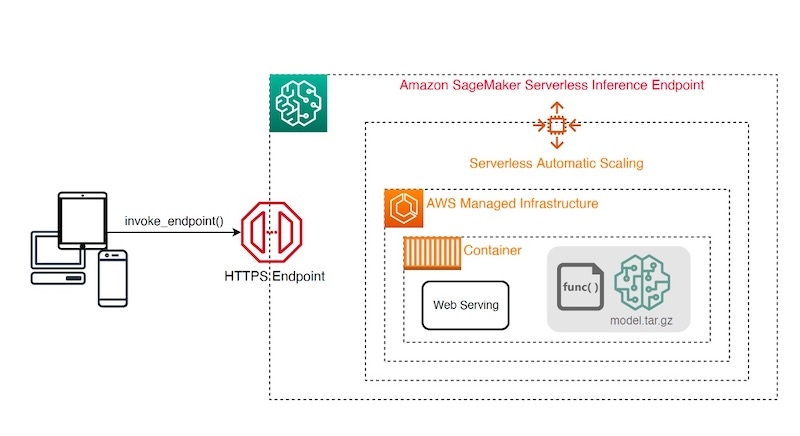

### Invoke Endpoint

In [9]:
import boto3
import sagemaker

sm_client = boto3.client("sagemaker", region_name=region)
smr_client = boto3.client("sagemaker-runtime", region_name="us-east-1")

print("-------------- SageMaker Endpoint List --------------")
endpoints = sm_client.list_endpoints(StatusEquals="InService")
for endpoint in endpoints['Endpoints']:
    print(endpoint['EndpointName'])

print("")
print("Enter endpoint name to use the model")
print("-------------------------------------")
endpoint_name = input()


# our requests and responses will be in json format so we specify the serializer and the deserializer

#embed_predictor = sagemaker.Predictor(
#    endpoint_name = endpoint_name,
#    sagemaker_session = sagemaker.session.Session(),  # sagemaker session for interacting with different AWS APIs
#    serializer = sagemaker.serializers.JSONSerializer(),
#    deserializer = sagemaker.deserializers.JSONDeserializer()
#)
print("")
print("Model loaded!")

-------------- SageMaker Endpoint List --------------
Qwen-14B-Chat-LMI-2023-11-20-18-09-48-852
chatglm3-6b-LMI-2023-11-20-15-52-19-414
Qwen-7B-Chat-LMI-2023-11-20-15-49-31-607
chatglm3-6b-TGI-2023-11-20-05-33-15-627
Llama-2-7b-chat-fp16-TGI-2023-11-19-06-12-55-594
Llama-2-7b-chat-fp16-LMI-2023-11-19-03-12-38-400
all-MiniLM-L6-v2-2023-11-18-15-07-22-162
jumpstart-dft-meta-textgeneration-llama-2-7b-f
mlops-jenkins-yolov4-prod
mlops-jenkins-yolov4-staging

Enter endpoint name to load Predictor
-------------------------------------


 all-MiniLM-L6-v2-2023-11-18-15-07-22-162


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [78]:
text = "This is an example sentence"

In [12]:
import json

print("Input Text")
print("----------")
text = input()

payload = {"inputs": text}
response = smr_client.invoke_endpoint(EndpointName=endpoint_name, 
                                      Body=json.dumps(payload),#.encode('utf-8'),
                                      Accept="application/json",
                                      ContentType="application/json",
                                      )
result = json.loads(response["Body"].read().decode('utf-8'))

#result = embed_predictor.predict({"inputs": text})

print("")
print(f"Vector length is {len(result['vectors'])}")
print(result)

Input Text
----------


 This is an example sentence



Vector length is 384
{'vectors': [0.06765694916248322, 0.06349599361419678, 0.04871309548616409, 0.07930496335029602, 0.037448104470968246, 0.002652771072462201, 0.03937496244907379, -0.007098469417542219, 0.05936143919825554, 0.03153697028756142, 0.06009810417890549, -0.05290517956018448, 0.040606789290905, -0.025930818170309067, 0.029842838644981384, 0.0011269228998571634, 0.07351484894752502, -0.050381824374198914, -0.122386634349823, 0.023702824488282204, 0.029726561158895493, 0.042476847767829895, 0.025633757933974266, 0.001995184225961566, -0.05691906064748764, -0.027159791439771652, -0.032903533428907394, 0.06602486968040466, 0.11900720745325089, -0.04587909206748009, -0.0726214274764061, -0.03258403390645981, 0.05234133079648018, 0.04505529627203941, 0.008252974599599838, 0.03670238330960274, -0.01394156739115715, 0.065391905605793, -0.02642720937728882, 0.00020636017143260688, -0.013664314523339272, -0.036281097680330276, -0.019504377618432045, -0.028973769396543503, 0.039427

## Langchain Integration

In [ ]:
import langchain

langchain.verbose = True

In [82]:
endpoint_name = ""

In [84]:
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.embeddings.sagemaker_endpoint import EmbeddingsContentHandler
from typing import Dict, List

class ContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, inputs: list[str], model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"inputs": inputs, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> List[List[float]]:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["vectors"]

embeddings = SagemakerEndpointEmbeddings(endpoint_name = endpoint_name,
                                         region_name="us-east-1",
                                         content_handler=ContentHandler()
                                        )

In [86]:
embeddings.embed_query("This is an example sentence")

[0.06765694916248322,
 0.06349599361419678,
 0.04871309548616409,
 0.07930496335029602,
 0.037448104470968246,
 0.002652771072462201,
 0.03937496244907379,
 -0.007098469417542219,
 0.05936143919825554,
 0.03153697028756142,
 0.06009810417890549,
 -0.05290517956018448,
 0.040606789290905,
 -0.025930818170309067,
 0.029842838644981384,
 0.0011269228998571634,
 0.07351484894752502,
 -0.050381824374198914,
 -0.122386634349823,
 0.023702824488282204,
 0.029726561158895493,
 0.042476847767829895,
 0.025633757933974266,
 0.001995184225961566,
 -0.05691906064748764,
 -0.027159791439771652,
 -0.032903533428907394,
 0.06602486968040466,
 0.11900720745325089,
 -0.04587909206748009,
 -0.0726214274764061,
 -0.03258403390645981,
 0.05234133079648018,
 0.04505529627203941,
 0.008252974599599838,
 0.03670238330960274,
 -0.01394156739115715,
 0.065391905605793,
 -0.02642720937728882,
 0.00020636017143260688,
 -0.013664314523339272,
 -0.036281097680330276,
 -0.019504377618432045,
 -0.028973769396543503,

## Clean Up

In [ ]:
import boto3
#import sagemaker

sm_client = boto3.client("sagemaker", region_name=region)

print("-------------- SageMaker Endpoint List --------------")
endpoints = sm_client.list_endpoints(StatusEquals="InService")
for endpoint in endpoints['Endpoints']:
    print(endpoint['EndpointName'])

print("")
print("Enter endpoint name to delete the model")
print("---------------------------------------")
endpoint_name = input()

sm_client.delete_model(ModelName=endpoint_name)    
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)


#embed_predictor = sagemaker.Predictor(
#    endpoint_name = endpoint_name,
#    sagemaker_session = sagemaker.session.Session(),  # sagemaker session for interacting with different AWS APIs
#    serializer = sagemaker.serializers.JSONSerializer(),
#    deserializer = sagemaker.deserializers.JSONDeserializer()
#)

#embed_predictor.delete_model()
#embed_predictor.delete_endpoint()

print("")
print("Model deleted!")